<a href="https://colab.research.google.com/github/sarvparteek/ModelPredictiveControl/blob/master/rrt_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rapidly-Exploring Random Tree (RRT) Planning

## Notebook Setup
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to \"Reset all runtimes\"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [3]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  23.2M      0  0:00:08  0:00:08 --:--:-- 25.1M
Reading package lists...
Building dependency tree...
Reading state information...
libjpeg8 is already the newest version (8c-2ubuntu8).
libjpeg8 set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set to manually installed.
libxt6 is already the newest version (1:1.1.5-1).
libxt6 set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
zlib1g is already the newest v

In [0]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt

## Problem Description
In this problem set, you will write code for the Rapidly-Exploring Random Tree (RRT), which is an algorithm designed to efficiently search nonconvex, high-dimensional spaces by randomly building a space-filling tree. Building on this implementation you will also implement RRT*, a variant of RRT that converges towards an optimal solution.

RRTs easily handle problems with obstacles and differential constraints (nonholonomic and kinodynamic) and can also be viewed as a method to generate open-loop trajectories for nonlinear systems with state constraints. RRTs have been widely used in autonomous robotic motion planning. We will use the RRT to find a path from a starting location `start` to a goal location `goal` while avoiding `obstacles` in the form of circles. We will search over the 2D domain bounded by `bounds`. Take a look at the instantiation of the problem below.

In [0]:
start = np.array([11, 0]) # Start location
goal = np.array([6, 8]) # Goal location

obstacles = [ # circles parametrized by [x, y, radius]
        np.array([9, 6, 2]),
        np.array([9, 8, 1]),
        np.array([9, 10, 2]),
        np.array([4, 5, 2]),
        np.array([7, 5, 2]),
        np.array([4, 10, 1])
] 

bounds = np.array([-2, 15]) # Bounds in both x and y

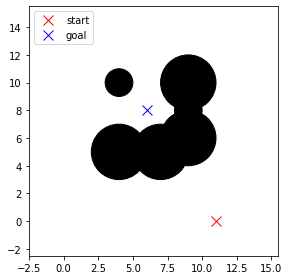

In [6]:
def plot_scene(obstacle_list, start, goal):
    ax = plt.gca()
    for o in obstacle_list:
        circle = plt.Circle((o[0], o[1]), o[2], color='k')
        ax.add_artist(circle)
    plt.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])
    plt.plot(start[0], start[1], "xr", markersize=10)
    plt.plot(goal[0], goal[1], "xb", markersize=10)
    plt.legend(('start', 'goal'), loc='upper left')
    plt.gca().set_aspect('equal')
    
plt.figure()
plot_scene(obstacles, start, goal)
plt.tight_layout()

## Rapidly-Exploring Random Tree (RRT) Planning

The RRT is constructed incrementally from samples drawn randomly from the search space and is inherently biased to grow towards large unsearched areas of the problem. The algorithm grows a tree rooted in the starting configuration, in our case the `start` location, through drawing random samples from the bounded search space. 

Remember that a tree consists of nodes containing data, in our case the position `p`, and a pointer to the parent node.
When a new node is sampled, it is connected to the nearest node in the tree. If the path connecting the nearest node to the sampled node does not violate constraints, the new node is added to the tree with the nearest node as the parent of the new node. In our setting, this means that if the path connecting the sampled node and the nearest node crosses an obstacle, the new node is discarded. The expansion of the tree continues until a connection to the `goal` has been found or a maximum number of iterations `max_iter` have been executed.

In most implementations the length of the path connecting a randomly sampled node and the nearest node is limited. We refer to this maximum distance as `max_extend_length`. Intuitively, `max_extend_length` limits the growth rate of the tree. 

While one can sample uniformly over the search space, it is common to bias sampling towards more promising regions. 
In our implementation, we introduce a small probability `goal_sample_rate` of sampling the goal as a new node instead of generating a sample uniformly over the search space. The higher this probability, the more greedily the tree grows towards the goal.

Your task is to complete the RRT implementation below to find a collision-free path connecting `start` and `goal` without colliding with circular `obstacles`. We provide implementations of many helper functions such as generating random nodes, checking paths between nodes for collisions, and more.

**These are the main steps of the first part of the exercise:**
1. Familiarize yourself with the RRT class. Go through the code and understand what each method does and what the members of the class contain.
2. Fill out the `final_path` method.
3. Complete the `plan` method by following the instructions inside the method.

Note that you only have to change the code where indicated by `# modify here`.

In [0]:
class RRT:
 
    class Node:
        def __init__(self, p):
            self.p = np.array(p)
            self.parent = None

    def __init__(self, start, goal, obstacle_list, bounds, 
                 max_extend_length=3.0, path_resolution=0.5, 
                 goal_sample_rate=0.05, max_iter=100):
        self.start = self.Node(start)
        self.goal = self.Node(goal)
        self.bounds = bounds
        self.max_extend_length = max_extend_length
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def plan(self):
        """Plans the path from start to goal while avoiding obstacles"""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # modify here: 
            # 1) Create a random node (rnd_node) inside 
            # the bounded environment
            rnd_node = self.get_random_node()
            # 2) Find nearest node (nearest_node)
            nearest_node = self.get_nearest_node(self.node_list, rnd_node)
            # 3) Get new node (new_node) by connecting
            # rnd_node and nearest_node. Hint: steer
            new_node = self.steer(nearest_node, rnd_node, self.max_extend_length)
            # 4) If the path between new_node and the
            # nearest node is not in collision, add it to the node_list
            if not self.collision(new_node, nearest_node, self.obstacle_list):
              self.node_list.append(new_node)
    
            # Don't need to modify beyond here
            # If the new_node is very close to the goal, connect it
            # directly to the goal and return the final path
            if self.dist_to_goal(self.node_list[-1].p) <= self.max_extend_length:
                final_node = self.steer(self.node_list[-1], self.goal, self.max_extend_length)
                if not self.collision(final_node, self.node_list[-1], self.obstacle_list):
                    return self.final_path(len(self.node_list) - 1)
        return None  # cannot find path

    def steer(self, from_node, to_node, max_extend_length=np.inf):
        """Connects from_node to a new_node in the direction of to_node
        with maximum distance max_extend_length
        """
        new_node = self.Node(to_node.p)
        d = from_node.p - to_node.p
        dist = np.linalg.norm(d)
        if dist > max_extend_length:
            # rescale the path to the maximum extend_length
            new_node.p  = from_node.p - d / dist * max_extend_length
        new_node.parent = from_node
        return new_node

    def dist_to_goal(self, p):
        """Distance from p to goal"""
        return np.linalg.norm(p - self.goal.p)

    def get_random_node(self):
        """Sample random node inside bounds or sample goal point"""
        if np.random.rand() > self.goal_sample_rate:
            # Sample random point inside boundaries
            rnd = self.Node(np.random.rand(2)*(self.bounds[1]-self.bounds[0]) + self.bounds[0])
        else:  
            # Select goal point
            rnd = self.Node(self.goal.p)
        return rnd
    
    @staticmethod
    def get_nearest_node(node_list, node):
        """Find the nearest node in node_list to node"""
        dlist = [np.sum(np.square((node.p - n.p))) for n in node_list]
        minind = dlist.index(min(dlist))
        return node_list[minind]
    
    @staticmethod
    def collision(node1, node2, obstacle_list):
        """Check whether the path connecting node1 and node2 
        is in collision with anyting from the obstacle_list
        """
        p1 = node2.p
        p2 = node1.p 
        for o in obstacle_list:
            center_circle = o[0:2]
            radius = o[2]
            d12 = p2 - p1 # the directional vector from p1 to p2
            # defines the line v(t) := p1 + d12*t going through p1=v(0) and p2=v(1)
            d1c = center_circle - p1 # the directional vector from circle to p1
            # t is where the line v(t) and the circle are closest
            # Do not divide by zero if node1.p and node2.p are the same.
            # In that case this will still check for collisions with circles
            t = d12.dot(d1c) / (d12.dot(d12) + 1e-7)
            t = max(0, min(t, 1)) # Our line segment is bounded 0<=t<=1
            d = p1 + d12*t # The point where the line segment and circle are closest
            is_collide = np.sum(np.square(center_circle-d)) < radius**2
            if is_collide:
                return True # is in collision
        return False # is not in collision
    
    def final_path(self, goal_ind):
        """Compute the final path from the goal node to the start node"""
        path = [self.goal.p]
        node = self.node_list[goal_ind]
        # modify here: Generate the final path from the goal node to the start node.
        # We will check that path[0] == goal and path[-1] == start
        path.append(node.p)
        while node != self.start:
          node = node.parent
          path.append(node.p)
        return path

    def draw_graph(self):
        for node in self.node_list:
            if node.parent:
                plt.plot([node.p[0], node.parent.p[0]], [node.p[1], node.parent.p[1]], "-g")

You can view the result of your implementation below. If you did everything correctly, the RRT should be able to find a feasible path from the start to the goal location.

In [0]:
np.random.seed(7)
rrt = RRT(start=start,
          goal=goal,
          bounds=bounds,
          obstacle_list=obstacles)
path_rrt = rrt.plan()

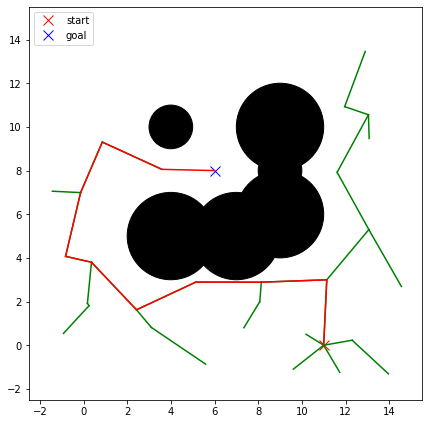

In [77]:
plt.figure(figsize=(6,6))
plot_scene(obstacles, start, goal)
rrt.draw_graph()
if path_rrt is None:
    print("No viable path found")
else:
    plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
plt.tight_layout()

An RRT can also be considered as a Monte-Carlo method to bias search into the largest unoccupied regions of a graph in configuration space. This means that the tree preferably expands towards large unsearched areas. If your above implementation of the RRT is correct, you will be able to observe this behavior by investigating the tree at a different number of node expansions. It is worth taking some time to think about how this method of expanding the tree uniformly at random over the whole search space differs from breadth-first search or depth-first search.

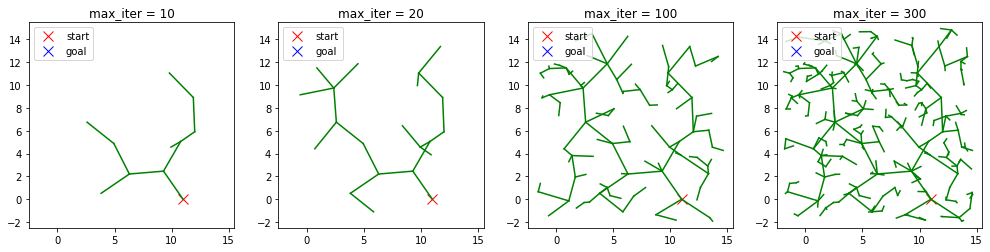

In [78]:
max_iter_array = [10, 20, 100, 300]
plt.figure(figsize=(14,5))
goal_out_of_bound = np.array([100,100])
for i in range(4):
    plt.subplot(1, 4, i+1)
    np.random.seed(9)
    rrt = RRT(start=start,
              goal=goal_out_of_bound,
              bounds=bounds,
              obstacle_list=[],
              goal_sample_rate=0.0, 
              max_iter=max_iter_array[i])
    path = rrt.plan()
    plot_scene([], start, goal_out_of_bound)
    rrt.draw_graph()
    plt.title('max_iter = {}'.format(max_iter_array[i]))
plt.tight_layout()

# RRT*
In the previous RRT example, we stopped the iteration once a path connecting the `start` and `goal` region was found without colliding with the obstacles. Instead of asking for <em>any</em> feasible solution, we may ask for the shortest path instead. To do so, we may continue expanding nodes in the tree. Nonetheless, it can be shown that the RRT algorithm almost always converges to a non-optimal solution.

[RRT*](http://roboticsproceedings.org/rss06/p34.pdf) is an improved version of RRT which exhibits asymptotic optimality: When the number of nodes approaches infinity, the RRT* algorithm will deliver the shortest possible path to the goal. The basic principle of RRT* is the same as RRT, but (i) each node keeps track of the cost of the unique path from `start` to the node, and (ii) RRT* is essentially <em>rewiring</em> the tree as it discovers new lower-cost paths reaching the nodes that are already in the tree. You will code the rewiring part of the algorithm.

**These are the main steps of the second part of the exercise:**
1. Familiarize yourself with the RRTStar class. Go through the code, understand the components and see what has been implemented already that might come in handy later on.
2. Complete the `choose_parent` method by following the instructions inside the method and the description below.
3. Implement the `rewire` method.

Note that you only have to change the code where indicated by `# modify here`.

As mentioned above, RRT*'s main difference from RRT is the dynamic rewiring when sampling a new node. First, a new feasible node is sampled like in RRT. Then, the algorithm chooses the best parent for the new node from a set of nodes that are close to the new node. This basically describes the search for the lowest cost way of getting to the sampled new node from any other node. In principle, we could search over the whole graph but we limit ourselves to the close proximity to avoid poor scaling as the graph grows. The procedure of searching for the best parent should be implemented in `choose_parent`.

In a second step, the `rewire` function checks whether the cost of the nodes in the vicinity of the sampled node can be decreased by rewiring them to the newly added node. If the cost can indeed be decreased, the neighbor is rewired to the newly added node.

While this explanation should be enough to complete the exercise, it may be interesting to have a look at the original paper [here](http://roboticsproceedings.org/rss06/p34.pdf).

In [0]:
class RRTStar(RRT):
    
    class Node(RRT.Node):
        def __init__(self, p):
            super().__init__(p)
            self.cost = 0.0

    def __init__(self, start, goal, obstacle_list, bounds,
                 max_extend_length=5.0,
                 path_resolution=0.5,
                 goal_sample_rate=0.0,
                 max_iter=200,
                 connect_circle_dist=50.0
                 ):
        super().__init__(start, goal, obstacle_list, bounds, max_extend_length,
                         path_resolution, goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal = self.Node(goal)

    def plan(self):
        """Plans the path from start to goal while avoiding obstacles"""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # Create a random node inside the bounded environment
            rnd = self.get_random_node()
            # Find nearest node
            nearest_node = self.get_nearest_node(self.node_list, rnd)
            # Get new node by connecting rnd_node and nearest_node
            new_node = self.steer(nearest_node, rnd, self.max_extend_length)
            # If path between new_node and nearest node is not in collision:
            if not self.collision(new_node, nearest_node, self.obstacle_list):
                near_inds = self.near_nodes_inds(new_node)
                # Connect the new node to the best parent in near_inds
                new_node = self.choose_parent(new_node, near_inds)
                self.node_list.append(new_node)
                # Rewire the nodes in the proximity of new_node if it improves their costs
                self.rewire(new_node, near_inds)
        last_index, min_cost = self.best_goal_node_index()
        if last_index:
            return self.final_path(last_index), min_cost
        return None, min_cost

    def choose_parent(self, new_node, near_inds):
        """Set new_node.parent to the lowest resulting cost parent in near_inds and
        new_node.cost to the corresponding minimal cost
        """
        min_cost = np.inf
        best_near_node = None
        # modify here: Go through all near nodes and evaluate them as potential parent nodes by
        # 1) checking whether a connection would result in a collision,
        # 2) evaluating the cost of the new_node if it had that near node as a parent,
        # 3) picking the parent resulting in the lowest cost and updating
        #    the cost of the new_node to the minimum cost.
        for i in near_inds:
          near_node = self.node_list[i]
          if not self.collision(new_node, near_node, self.obstacle_list):
            cost = self.new_cost(near_node, new_node)
            if cost < min_cost:
              min_cost       = cost
              best_near_node = near_node

        # Don't need to modify beyond here
        new_node.cost   = min_cost
        new_node.parent = best_near_node
        return new_node
    
    def rewire(self, new_node, near_inds):
        """Rewire near nodes to new_node if this will result in a lower cost"""
        # modify here: Go through all near nodes and check whether rewiring them
        # to the new_node would: 
        # A) Not cause a collision and
        # B) reduce their own cost.
        # If A and B are true, update the cost and parent properties of the node.
        for i in near_inds:
          near_node = self.node_list[i]
          if not self.collision(new_node, near_node, self.obstacle_list):
            new_cost = self.new_cost(new_node, near_node)
            if new_cost < near_node.cost:
              near_node.cost   = new_cost
              near_node.parent = new_node

        # Don't need to modify beyond here
        self.propagate_cost_to_leaves(new_node)

    def best_goal_node_index(self):
        """Find the lowest cost node to the goal"""
        min_cost = np.inf
        best_goal_node_idx = None
        for i in range(len(self.node_list)):
            node = self.node_list[i]
            # Has to be in close proximity to the goal
            if self.dist_to_goal(node.p) <= self.max_extend_length:
                # Connection between node and goal needs to be collision free
                if not self.collision(self.goal, node, self.obstacle_list):
                    # The final path length
                    cost = node.cost + self.dist_to_goal(node.p) 
                    if node.cost + self.dist_to_goal(node.p) < min_cost:
                        # Found better goal node!
                        min_cost = cost
                        best_goal_node_idx = i
        return best_goal_node_idx, min_cost

    def near_nodes_inds(self, new_node):
        """Find the nodes in close proximity to new_node"""
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt((np.log(nnode) / nnode))
        dlist = [np.sum(np.square((node.p - new_node.p))) for node in self.node_list]
        near_inds = [dlist.index(i) for i in dlist if i <= r ** 2]
        return near_inds

    def new_cost(self, from_node, to_node):
        """to_node's new cost if from_node were the parent"""
        d = np.linalg.norm(from_node.p - to_node.p)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):
        """Recursively update the cost of the nodes"""
        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [80]:
np.random.seed(7)
rrt_star = RRTStar(start=start,
          goal=goal,
          bounds=bounds,
          obstacle_list=obstacles)
path_rrt_star, min_cost = rrt_star.plan()
print('Minimum cost: {}'.format(min_cost))

# Check the cost
def path_cost(path):
    return sum(np.linalg.norm(path[i] - path[i + 1]) for i in range(len(path) - 1))

if path_rrt_star:
    print('Length of the found path: {}'.format(path_cost(path_rrt_star)))

Minimum cost: 16.95031126986332
Length of the found path: 16.95031126986332


You should be able to achieve a minimum path length below 17.5 if you implemented everything correctly and be able to see a characteristic fan-like pattern generated by the RRT* paths.

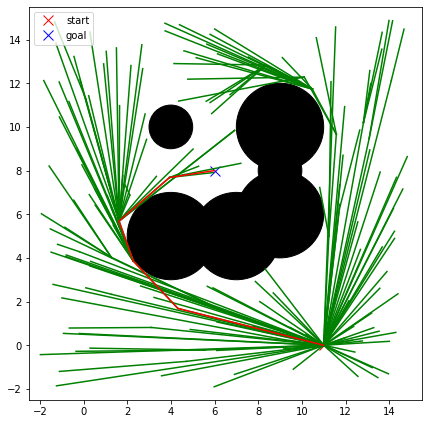

In [81]:
plt.figure(figsize=(6,6))
plot_scene(obstacles, start, goal)
rrt_star.draw_graph()
if path_rrt_star is None:
    print("No viable path found")
else:
    plt.plot([x for (x, y) in path_rrt_star], [y for (x, y) in path_rrt_star], '-r')
plt.tight_layout()

## Autograding
You can check your work by running the following cell.

In [84]:
from underactuated.exercises.planning.rrt_planning.test_rrt_planning import TestRRTPlanning
from underactuated.exercises.grader import Grader
Grader.grade_output([TestRRTPlanning], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 14/14.

Score for Test RRT is 7/7.

Score for Test RRT* is 7/7.
